### Import modules

In [1]:
import math
import pandas as pd
import seaborn as sns
import numpy as np
import datetime as dt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input
from keras.callbacks import EarlyStopping
plt.style.use('fivethirtyeight')

### Define functions to compute technical indicators

In [2]:
# Simple Moving Average 
def SMA(data, ndays): 
    SMA = pd.Series(data['Close'].rolling(ndays).mean(), name = 'SMA_'+str(ndays)) 
    data = data.join(SMA) 
    return data

# Bollinger Bands
def BBANDS(data, ndays):
    MA = data['Close'].rolling(ndays).mean()
    SD = data['Close'].rolling(ndays).std()
    data['UpperBBand_'+str(ndays)] = MA + (2 * SD) 
    data['LowerBBand_'+str(ndays)] = MA - (2 * SD)
    return data

# Relative Strenth Index
def RSI(data, ndays):
    close = data['Close']
    close_delta = close.diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    ma_up = up.ewm(com = ndays - 1, adjust=True, min_periods = ndays).mean()
    ma_down = down.ewm(com = ndays - 1, adjust=True, min_periods = ndays).mean()
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    data['RSI_'+str(ndays)] = rsi
    return data

# Calculate money flow index
def gain(x):
    return ((x > 0) * x).sum()
def loss(x):
    return ((x < 0) * x).sum()
def MFI(data, ndays):
    high = data['High']
    low = data['Low']
    close = data['Close']
    volume = data['Volume']
    typical_price = (high + low + close)/3
    money_flow = typical_price * volume
    mf_sign = np.where(typical_price > typical_price.shift(1), 1, -1)
    signed_mf = money_flow * mf_sign
    mf_avg_gain = signed_mf.rolling(ndays).apply(gain, raw=True)
    mf_avg_loss = signed_mf.rolling(ndays).apply(loss, raw=True)
    mfi = (100 - (100 / (1 + (mf_avg_gain / abs(mf_avg_loss))))).to_numpy()
    data['MFI_'+str(ndays)] = mfi
    return data

# Calculate MACD
def MACD(data, short=12, long=26, signal=9):
    k = data['Close'].ewm(span=short, adjust=False, min_periods=short).mean()
    d = data['Close'].ewm(span=long, adjust=False, min_periods=long).mean()
    macd = k - d
    data['MACD'] = macd
    data['MACD_S'] = macd.ewm(span=signal, adjust=False, min_periods=signal).mean()
    return data

#Compute Roc
def ROC(data, ndays):
    N = data['Close'].diff(ndays)
    D = data['Close'].shift(ndays)
    ROC = pd.Series(N/D, name='ROC_'+str(ndays))
    data = data.join(ROC)
    return data


### Define functions to prepare dataset

In [3]:
# function to generate technical indicators
def data_prep(data):
    data.Date = pd.to_datetime(data.Date, format='%d-%m-%Y')
    data = data[data['Volume']!=0]
    Y = pd.Series(data['Adjusted Close'].diff()>0, name='Y')
    data = data.join(Y)
    Growth = pd.Series(data['Adjusted Close'].div(data['Adjusted Close'].shift()), name='Growth')
    data = data.join(Growth)
    data = SMA(data, ndays=10) # SMA 10 days
    data = SMA(data, ndays=30) # SMA 30 days
    data = BBANDS(data, ndays=20) # BBands 20 days
    data = RSI(data, ndays=10) # RSI 10 days
    data = MFI(data, ndays=10) # RSI 10 days
    data = MACD(data)
    data = ROC(data, ndays=2) # ROC 2 days
    data = data.dropna() # drop all rows with NA
    return data

# function to scale feature
def scale_feature(feature, scale_range=(0,1), log_transform=True):
    if log_transform:
        feature = np.log(feature + 0.000001)
    feature = np.array(feature).reshape(-1,1)
    scaler = MinMaxScaler(feature_range=scale_range)
    return scaler.fit_transform(feature)

# function to scale selected features in a dataset
def scale_data(data, scale_range=(0,1)):
    data = data.copy()
    for c in data.columns:
        if ((c=='Date') or (c=='Y')):
            continue
        elif ((c=='ROC_2') or (c=='MACD') or (c=='MACD_S') or (c=='GROWTH')):
            data[c] = scale_feature(data[c], scale_range=scale_range, log_transform=False)
        else:
            data[c] = scale_feature(data[c], scale_range=scale_range)
    return data

# compute PCA and append to dataset
def append_PC(data, features, pc):
    data=data.copy()
    x = data[features]
    pca = PCA(n_components=pc)
    pc_array = pca.fit_transform(x)
    for i in range(pc):
        data['PC_'+str(i+1)] = pc_array[:,i]
    return data

def get_stock_data(path, scale_range, log_transform, features, pc):
    data = pd.read_csv(path)
    data = data_prep(data)
    data_scaled = scale_data(data)
    data_scaled = append_PC(data_scaled, features=features, pc=pc)
    return data, data_scaled

### Define function to generate training and test sets

In [77]:
def build_train_test(data, features, window_size, n_future, train_start_date, train_end_date,
                      test_start_date, test_end_date):
    data = data.copy()
    encoder = LabelEncoder()
    data.Y = encoder.fit_transform(data.Y)
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    test_date = []
    for i in range(window_size, len(data) - n_future + 1):
        date = data.iloc[i]['Date'].date()
        if (date>=pd.to_datetime(train_start_date)) & (date<=pd.to_datetime(train_end_date)):
            x_train.append(np.array(data.iloc[i-window_size-1:i-1][features]))
            y_train.append(np.array(data.iloc[i]['Y']))
        if (date>=pd.to_datetime(test_start_date)) & (date<=pd.to_datetime(test_end_date)):
            x_test.append(np.array(data.iloc[i-window_size-1:i-1][features]))
            y_test.append(np.array(data.iloc[i]['Y']))
            test_date.append(date)
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    return x_train, y_train, x_test, y_test, test_date

### Read stock data

In [5]:
pc_features = ['Adjusted Close', 'Growth', 'Volume', 'SMA_10', 'SMA_30', 'UpperBBand_20', 'LowerBBand_20',
            'RSI_10', 'MFI_10', 'MACD', 'MACD_S', 'ROC_2']
AAPL, AAPL_scaled = get_stock_data('../DATA/Stock Market Data/sp500/csv/AAPL.csv', scale_range=(0,1), log_transform=True, features=pc_features, pc=5)
ADBE, ADBE_scaled = get_stock_data('../DATA/Stock Market Data/nasdaq/csv/ADBE.csv', scale_range=(0,1), log_transform=True, features=pc_features, pc=5)
AMZN, AMZN_scaled = get_stock_data('../DATA/Stock Market Data/sp500/csv/AMZN.csv', scale_range=(0,1), log_transform=True, features=pc_features, pc=5)
COST, COST_scaled = get_stock_data('../DATA/Stock Market Data/sp500/csv/COST.csv', scale_range=(0,1), log_transform=True, features=pc_features, pc=5)
CSCO, CSCO_scaled = get_stock_data('../DATA/Stock Market Data/sp500/csv/CSCO.csv', scale_range=(0,1), log_transform=True, features=pc_features, pc=5)
GOOG, GOOG_scaled = get_stock_data('../DATA/Stock Market Data/sp500/csv/GOOG.csv', scale_range=(0,1), log_transform=True, features=pc_features, pc=5)
MSFT, MSFT_scaled = get_stock_data('../DATA/Stock Market Data/sp500/csv/MSFT.csv', scale_range=(0,1), log_transform=True, features=pc_features, pc=5)
NVDA, NVDA_scaled = get_stock_data('../DATA/Stock Market Data/nasdaq/csv/NVDA.csv', scale_range=(0,1), log_transform=True, features=pc_features, pc=5)
PEPS, PEPS_scaled = get_stock_data('../DATA/Stock Market Data/sp500/csv/PEP.csv', scale_range=(0,1), log_transform=True, features=pc_features, pc=5)
TSLA, TSLA_scaled = get_stock_data('../DATA/Stock Market Data/forbes2000/csv/TSLA.csv', scale_range=(0,1), log_transform=True, features=pc_features, pc=5)

In [10]:
stocks = {'AAPL': AAPL, 'ADBE': ADBE, 'AMZN': AMZN, 'COST': COST,
          'CSCO': CSCO, 'GOOG': GOOG, 'MSFT': MSFT, 'NVDA': NVDA,
          'PEPS': PEPS, 'TSLA': TSLA}

stocks_scaled = {'AAPL': AAPL_scaled, 'ADBE': ADBE_scaled, 'AMZN': AMZN_scaled, 'COST': COST_scaled,
          'CSCO': CSCO_scaled, 'GOOG': GOOG_scaled, 'MSFT': MSFT_scaled, 'NVDA': NVDA_scaled,
          'PEPS': PEPS_scaled, 'TSLA': TSLA_scaled}

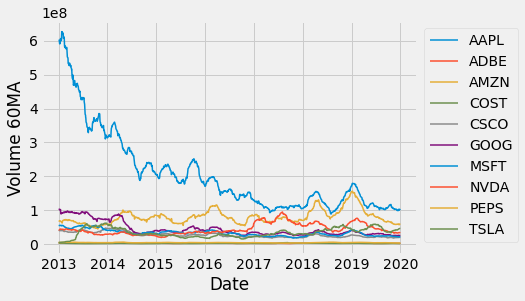

In [7]:
for k, v in stocks.items():
    v['Volume 60MA'] = v['Volume'].rolling(60).mean()
    sns.lineplot(data=v[(v.Date>='2013-01-01') & (v.Date<='2019-12-31')], x='Date', y='Volume 60MA', label=k,linewidth = 1.5)
plt.legend(loc = 2, bbox_to_anchor = (1,1))
plt.show()

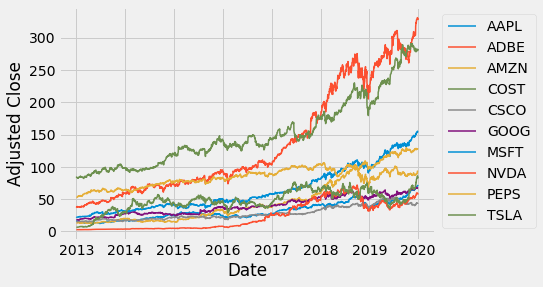

In [8]:
for k, v in stocks.items():
    sns.lineplot(data=v[(v.Date>='2013-01-01') & (v.Date<='2019-12-31')], x='Date', y='Adjusted Close', label=k,linewidth = 1.5)
plt.legend(loc = 2, bbox_to_anchor = (1,1))
plt.show()

### Set parameters

In [9]:
train_start_date = '2013-01-01'
train_end_date = '2018-12-31'
test_start_date = '2019-01-01'
test_end_date = '2019-12-31'
window_size = 60 # number of past observation for LSTM to train and predict
n_future = 1 # number of feature data points to predict
dropout_rate = 0.2
nodes = 32 # number of nodes in LSTM
lstm_activation = 'relu' # activation function used for the LSTM layers (softsign, relu, sigmoid)
features = ['Y','Adjusted Close', 'Volume', 'SMA_10', 'SMA_30', 'UpperBBand_20', 'LowerBBand_20',
            'RSI_10', 'MFI_10', 'MACD', 'MACD_S', 'ROC_2']
# features = ['Y','PC_1', 'PC_2', 'PC_3']
n_features = len(features)
optimizer = 'adam'
loss = 'binary_crossentropy'
metrics = ['accuracy']
epochs = 100
patience = 25 # patience for the early stopping (number of epochs)
batch_size = 500

In [78]:
x_train = {}
y_train = {}
x_test = {}
y_test = {}

for k, v in stocks_scaled.items():
    x_trn, y_trn, x_tst, y_tst, test_date = build_train_test(v, features, window_size, n_future, train_start_date, train_end_date, test_start_date, test_end_date)
    x_train.update({k: x_trn})
    y_train.update({k: y_trn})
    x_test.update({k: x_tst})
    y_test.update({k: y_tst})

### Build LSTM Models

In [60]:
def build_lstm(window_size, n_features, dropout_rate, n_future,
               lstm_activation, nodes, optimizer, loss, metrics, name):
    model = Sequential()
    model.add(LSTM(nodes, dropout=dropout_rate, return_sequences=True,
            activation=lstm_activation, input_shape=(window_size, n_features)))
    model.add(LSTM(nodes, dropout=dropout_rate, return_sequences=False,
            activation=lstm_activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    model._name = name
    return model

early_stop = EarlyStopping(monitor='loss', mode='min', verbose=0, patience=patience)

In [61]:
lstm_models = {}

for k in stocks.keys():
    m = build_lstm(window_size, n_features, dropout_rate, n_future,
               lstm_activation, nodes, optimizer, loss, metrics, name=k)
    lstm_models.update({k: m})

In [62]:
for k, v in lstm_models.items():
    print('Training LSTM model for', k, '...')
    v.fit(x_train[k], y_train[k], callbacks=[early_stop],
        epochs=epochs, batch_size=batch_size, verbose=0)

Training LSTM model for AAPL ...
Training LSTM model for ADBE ...
Training LSTM model for AMZN ...
Training LSTM model for COST ...
Training LSTM model for CSCO ...
Training LSTM model for GOOG ...
Training LSTM model for MSFT ...
Training LSTM model for NVDA ...
Training LSTM model for PEPS ...
Training LSTM model for TSLA ...


In [63]:
pred = {}
pred_class = {}
for k, v in lstm_models.items():
    p = v.predict(x_test[k])
    p = [x[0] for x in p]
    p_class = [x>0.5 for x in p]
    pred.update({k: tuple(p)})
    pred_class.update({k: tuple(p_class)})

8/8 [==============================] - 0s 8ms/step


### Assess Performance

In [64]:
import warnings
warnings.filterwarnings("ignore")

for k in stocks.keys():
    print('\033[1m' + k + '\033[0m')
    print('Naive Maj Class:', round(sum(y_test[k]==1)/len(y_test[k]),2))
    print('Classification Report:\n', classification_report(y_test[k], pred_class[k]))

AAPL
Naive Maj Class: 0.58
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       105
           1       0.58      1.00      0.74       147

    accuracy                           0.58       252
   macro avg       0.29      0.50      0.37       252
weighted avg       0.34      0.58      0.43       252

ADBE
Naive Maj Class: 0.56
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       110
           1       0.56      1.00      0.72       142

    accuracy                           0.56       252
   macro avg       0.28      0.50      0.36       252
weighted avg       0.32      0.56      0.41       252

AMZN
Naive Maj Class: 0.54
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       116
           1       0.54      1.00      0.70       136

    accuracy                 

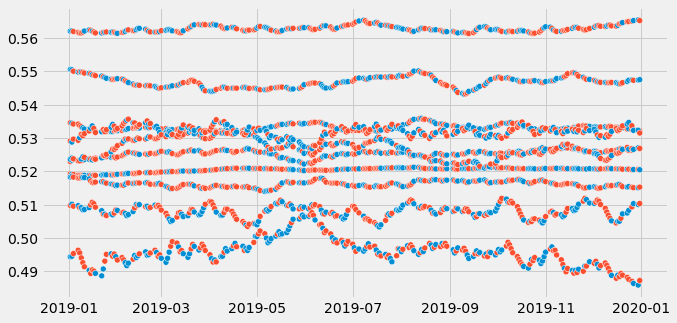

In [83]:
plt.figure(figsize=(10,5))
for k in stocks.keys():
    sns.scatterplot(x=test_date, y=list(pred[k]), hue=y_test[k], legend=False)